In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# looking at the column names in the dataset
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# looking at the column names in the dataset
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Finding the maximum / latest date in the dataset
session.query(Measurement.date).\
    order_by(Measurement.date.desc()).limit(1).all()

[('2017-08-23')]

In [10]:
# Storing the max date into a variable
max_date = dt.date(2017, 4, 8)

# Exploratory Climate Analysis

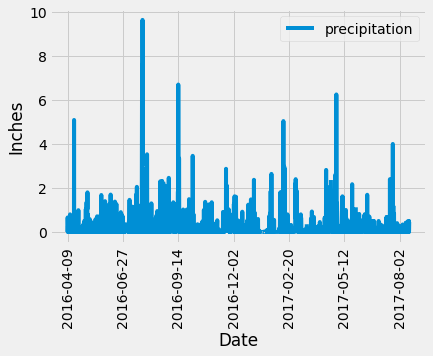

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Perform a query to retrieve the data and precipitation scores
query_date = max_date - dt.timedelta(days = 365.24)

precipitation_data_df = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).all(), columns = ["Date", "precipitation"])

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data_df.set_index("Date", inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data_df.plot()
plt.xticks(rotation = 90)
plt.ylabel("Inches")
plt.savefig("output/fig1.png");

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data_df.describe()

,precipitation
count,2781.000000
mean,0.195638
std,0.523703
min,0.000000
25%,0.000000
50%,0.020000
75%,0.150000
max,9.640000


In [13]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station).\
    group_by(Station.station).all()

print(f"The number of stations in the dataset is {len(num_stations)}")
print(num_stations)

The number of stations in the dataset is 9
[('USC00511918',), ('USC00513117',), ('USC00514830',), ('USC00516128',), ('USC00517948',), ('USC00518838',), ('USC00519281',), ('USC00519397',), ('USC00519523',)]


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(1)).\
    group_by(Measurement.station).\
    order_by(func.count(1).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

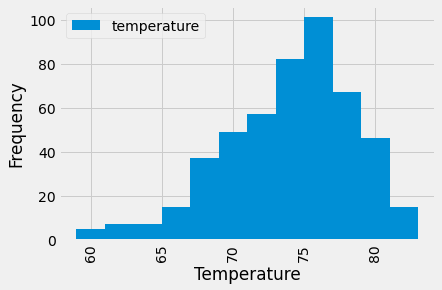

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
precipitation_data_df = pd.DataFrame(session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > query_date).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all(), columns = ["Date", "temperature"])

# plot the results as a histogram
precipitation_data_df.plot(kind = "hist", bins = 12)
plt.xticks(rotation = 90)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("output/fig2.png");

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = "2017-01-01"
end_date = "2017-01-15"

trip_temps = calc_temps(start_date, end_date)

min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

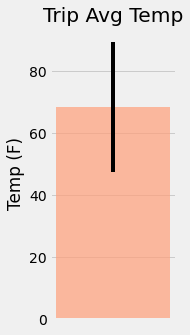

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize = (2, 5))
plt.bar(x = 1, height = avg_temp, color = "lightsalmon", alpha = 0.7, yerr = (max_temp - min_temp))

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])

plt.savefig("output/fig3.png")
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_rain_total = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for record in trip_rain_total:
    print(record)

('USC00516128', 0.64, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00514830', 0.63, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519523', 0.61, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00513117', 0.35, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519281', 0.21000000000000002, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2017, 1, 1)
end_date = dt.date(2017, 1, 15)

# Use the start and end date to create a range of dates
trip_len = (end_date - start_date).days + 1

trip_dates = [(start_date + dt.timedelta(days = i)).isoformat() for i in range(0, trip_len)]

# Strip off the year and save a list of %m-%d strings
trip_dates = [trip_dates[i][5:] for i in range(0, len(trip_dates))]

# Loop through the list of %m-%d strings and calculate the normals for each date
normal_temps = [daily_normals(i) for i in trip_dates]

normal_temps_clean = []

for i in range(0, len(normal_temps)):
    normal_temps_clean.append(normal_temps[i][0])

normal_temps_clean

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normal_temps_clean, columns = ['Min', 'Avg', 'Max'])

trip_df["Date"] = trip_dates
trip_df.set_index("Date", inplace = True)

trip_df

,Min,Avg,Max
Date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0
01-08,57.0,67.160714,75.0
01-09,58.0,67.929825,78.0


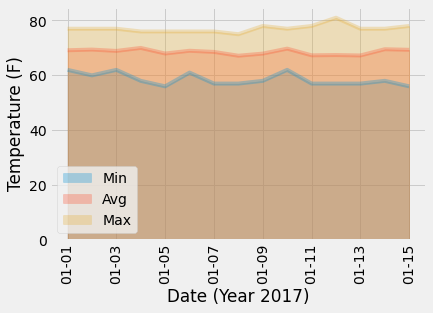

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked = False, alpha = 0.3)
plt.xticks(rotation = 90)
plt.xlabel("Date (Year 2017)")
plt.ylabel("Temperature (F)")
plt.savefig("output/fig4.png");

In [25]:
# Temperature Analysis I
connection = engine.connect()

measurements_df = pd.read_sql("""
SELECT * FROM measurement
""", connection).sort_values(by = "date")
stations_df = pd.read_sql("SELECT * FROM station", connection)

measurements_df["date"] = pd.to_datetime(measurements_df["date"])
june_df = measurements_df.loc[measurements_df["date"].dt.month == 6]
december_df = measurements_df.loc[measurements_df["date"].dt.month == 12]

In [26]:
print(f"The average temperature across all stations in June is: {june_df['tobs'].mean()}")
print(f"The average temperature across all stations in December is: {december_df['tobs'].mean()}")

The average temperature across all stations in June is: 74.94411764705882
The average temperature across all stations in December is: 71.04152933421226


In [27]:
import scipy.stats as stats

# Using an independent T-test to determine if there is statistical significance between the two groups, temperature in June vs temperature in December
stats.ttest_ind(june_df.tobs, december_df.tobs, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

#### The results show the T-stat is 31.36, which is very high, indicating a strong level of statistical significance between the temperature data in June vs the temperature data in December